In [ ]:
  import os
# Path to the zip file in Google Drive
zip_path = '/content/drive/MyDrive/pathhole/Potholedetection.zip'

In [ ]:
import zipfile

# Destination directory to unzip the files
extract_dir = '/content/pathhole/Potholedetection'

with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(extract_dir)

# List files to verify
for root, dirs, files in os.walk(extract_dir):
    for file in files:
        print(os.path.join(root, file))

/content/pathhole/Potholedetection/data.yaml
/content/pathhole/Potholedetection/README.dataset.txt
/content/pathhole/Potholedetection/README.roboflow.txt
/content/pathhole/Potholedetection/train/labels/261_jpg.rf.9a13ac61be23105268c1d8beb9ffa098.txt
/content/pathhole/Potholedetection/train/labels/91_jpg.rf.df7f7c1dfad236aa8124d005ecd03d5d.txt
/content/pathhole/Potholedetection/train/labels/5_jpg.rf.70ecf86781f55df1fa9eba7b5d9da604.txt
/content/pathhole/Potholedetection/train/labels/558_jpg.rf.82092388c72d836759659f0db3faecba.txt
/content/pathhole/Potholedetection/train/labels/340_jpg.rf.bfe91d98e32c5fed52293e78a7986037.txt
/content/pathhole/Potholedetection/train/labels/489_jpg.rf.b05f037b6fc18050f6e4849d4a77915e.txt
/content/pathhole/Potholedetection/train/labels/335_jpg.rf.22822453842306261dbfa1b7bbd159b1.txt
/content/pathhole/Potholedetection/train/labels/47_jpg.rf.22ee78ed7c1e428bdb06d169ea9d8522.txt
/content/pathhole/Potholedetection/train/labels/123_jpg.rf.32b68664e289497a25d8b7f

In [ ]:
!pip install ultralytics
!pip install -U ipywidgets
!pip install wandb


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 801.6/801.6 kB 9.5 MB/s eta 0:00:00
  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (23.7 MB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (823 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (14.1 MB)
  Using cached nvidia_cudnn_cu12-8.9.2.26-py3-none-manylinux1_x86_64.whl (731.7 MB)
  Using cached nvidia_cublas_cu12-12.1.3.1-py3-none-manylinux1_x86_64.whl (410.6 MB)
  Using cached nvidia_cufft_cu12-11.0.2.54-py3-none-manylinux1_x86_64.whl (121.6 MB)
  Using cached nvidia_curand_cu12-10.3.2.106-py3-none-manylinux1_x86_64.whl (56.5 MB)
  Using cached nvidia_cusolver_cu12-11.4.5.107-py3-none-manylinux1_x86_64.whl (124.2 MB)
  Using cached nvidia_cusparse_cu12-12.1.0.106-py3-none-manylinux1_x86_64.whl (196.0 MB)
  Using cached nvidia_nccl_cu12-2.20.5-py3-none-manylinux2014_x86_64.whl (176.2 MB)
  Using cached nvidia_nvtx_cu12-12.1.105-py3-none-m

In [ ]:
import os
import shutil
import numpy as np
import pandas as pd
import pickle
from tensorflow.keras.utils import to_categorical
import plotly.express as px
import matplotlib.pyplot as plt
import seaborn as sns
from ultralytics import YOLO
import cv2
from PIL import Image
import torch
from torch import nn
import random

In [ ]:
train_img_dir = '/content/pathhole/Potholedetection/train/images'
train_images = os.listdir(train_img_dir)

val_img_dir = '/content/pathhole/Potholedetection/valid/images'
val_images = os.listdir(val_img_dir)

train_labels_dir = '/content/pathhole/Potholedetection/train/labels'
val_labels_dir = '/content/pathhole/Potholedetection/valid/labels'

In [ ]:
label_list = ['pothole']

In [ ]:
def label_name(label_class):
    if 0 <= label_class < len(label_list):
        return label_list[label_class]
    else:
        return "none"

def load_labels(images, labels_dir):
    labels = []
    for img in images:
        label_path = os.path.join(labels_dir, img.replace('.jpg', '.txt'))
        try:
            with open(label_path, "r") as file:
                text = file.read().strip()
            if len(text) < 1:
                labels.append('None')
            else:
                labels.append(int(text.split()[0]))
        except FileNotFoundError:
            labels.append('None')
    return labels

train_labels = load_labels(train_images, train_labels_dir)
val_labels = load_labels(val_images, val_labels_dir)

def convert_labels(labels):
    return [int(label) if label != 'None' else -1 for label in labels]

train_labels = convert_labels(train_labels)
val_labels = convert_labels(val_labels)

In [ ]:
df_train = pd.DataFrame({
    'image_path': train_images,
    'label_class': train_labels
})
df_train['label_name'] = df_train['label_class'].apply(label_name)

df_val = pd.DataFrame({
    'image_path': val_images,
    'label_class': val_labels
})
df_val['label_name'] = df_val['label_class'].apply(label_name)


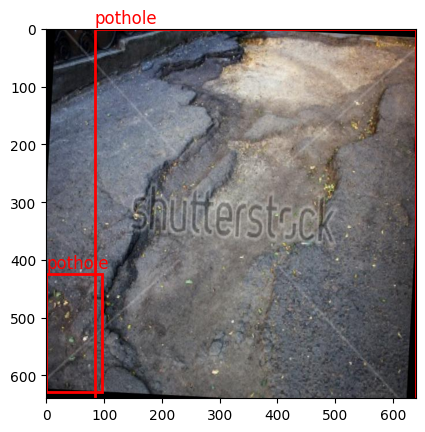

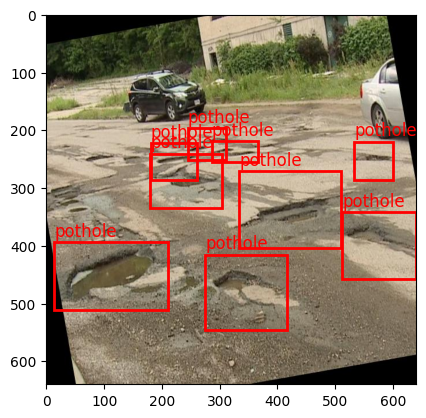

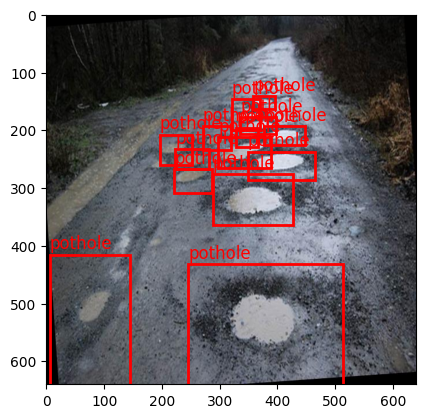

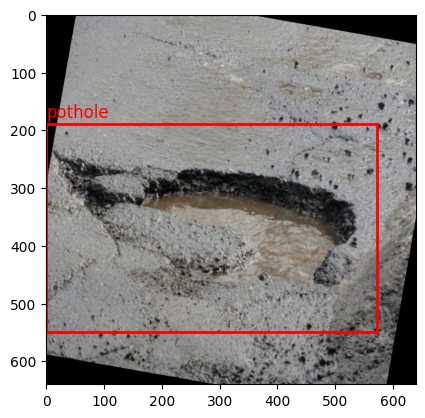

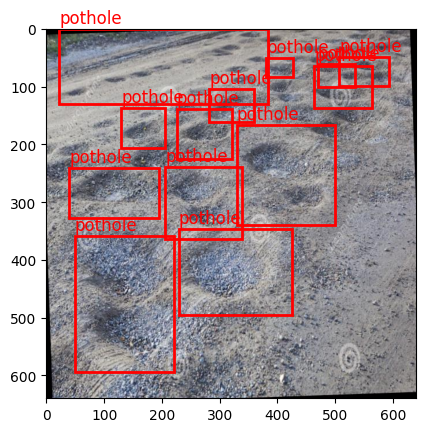

In [ ]:

import matplotlib.patches as patches

def plot_bounding_box(image_path, labels_dir):
    img = cv2.imread(image_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    label_path = os.path.join(labels_dir, os.path.basename(image_path).replace('.jpg', '.txt'))
    fig, ax = plt.subplots(1)
    ax.imshow(img)
    try:
        with open(label_path, 'r') as file:
            for line in file:
                class_id, x_center, y_center, width, height = map(float, line.split())
                x_center, y_center, width, height = x_center * img.shape[1], y_center * img.shape[0], width * img.shape[1], height * img.shape[0]
                rect = patches.Rectangle((x_center - width / 2, y_center - height / 2), width, height, linewidth=2, edgecolor='r', facecolor='none')
                ax.add_patch(rect)
                plt.text(x_center - width / 2, y_center - height / 2 - 10, label_name(int(class_id)), color='r', fontsize=12)
    except FileNotFoundError:
        print(f"Label file not found for {image_path}")
    plt.show()


for img_path in df_train['image_path'].sample(5).values:
    plot_bounding_box(os.path.join(train_img_dir, img_path), train_labels_dir)

In [ ]:
import torch
import torch.nn as nn

class SpatialAttention(nn.Module):
    def _init_(self, kernel_size=7):
        super(SpatialAttention, self)._init_()
        self.conv1 = nn.Conv2d(2, 1, kernel_size, padding=(kernel_size - 1) // 2, bias=False)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        avg_out = torch.mean(x, dim=1, keepdim=True)
        max_out, _ = torch.max(x, dim=1, keepdim=True)
        x = torch.cat([avg_out, max_out], dim=1)
        x = self.conv1(x)
        return self.sigmoid(x)

In [ ]:
import torch
import torch.nn as nn
from ultralytics import YOLO

class SpatialAttention(nn.Module):
    def __init__(self, kernel_size=7):
        super(SpatialAttention, self).__init__()
        assert kernel_size in (3, 7), 'kernel size must be 3 or 7'
        padding = 3 if kernel_size == 7 else 1

        self.conv1 = nn.Conv2d(2, 1, kernel_size, padding=padding, bias=False)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        avg_out = torch.mean(x, dim=1, keepdim=True)
        max_out, _ = torch.max(x, dim=1, keepdim=True)
        x = torch.cat([avg_out, max_out], dim=1)
        x = self.conv1(x)
        return self.sigmoid(x)

class YOLOv9WithAttention(nn.Module):
    def __init__(self, yolo_model):
        super(YOLOv9WithAttention, self).__init__()
        self.backbone = yolo_model.model.model[0]
        self.neck = yolo_model.model.model[1]
        self.head = yolo_model.model.model[2]
        self.spatial_attention = SpatialAttention(kernel_size=7)

    def forward(self, x):
        x = self.backbone(x)
        x = self.spatial_attention(x) * x
        x = self.neck(x)
        x = self.head(x)
        return x

# Load the pre-trained YOLOv9 model
yolo_model = YOLO("yolov9c.pt")

# Integrate the spatial attention module
model_with_attention = YOLOv9WithAttention(yolo_model)
import torch
import torch.nn as nn
from ultralytics import YOLO

class SpatialAttention(nn.Module):
    def __init__(self, kernel_size=7):
        super(SpatialAttention, self).__init__()
        assert kernel_size in (3, 7), 'kernel size must be 3 or 7'
        padding = 3 if kernel_size == 7 else 1

        self.conv1 = nn.Conv2d(2, 1, kernel_size, padding=padding, bias=False)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        avg_out = torch.mean(x, dim=1, keepdim=True)
        max_out, _ = torch.max(x, dim=1, keepdim=True)
        x = torch.cat([avg_out, max_out], dim=1)
        x = self.conv1(x)
        return self.sigmoid(x)

class YOLOv9WithAttention(nn.Module):
    def __init__(self, yolo_model):
        super(YOLOv9WithAttention, self).__init__()
        self.backbone = yolo_model.model.model[0]
        self.neck = yolo_model.model.model[1]
        self.head = yolo_model.model.model[2]
        self.spatial_attention = SpatialAttention(kernel_size=7)

    def forward(self, x):
        x = self.backbone(x)
        x = self.spatial_attention(x) * x
        x = self.neck(x)
        x = self.head(x)
        return x

# Load the pre-trained YOLOv9 model
yolo_model = YOLO("yolov9c.pt")

# Integrate the spatial attention module
model_with_attention = YOLOv9WithAttention(yolo_model)


100%|██████████| 49.4M/49.4M [00:00<00:00, 253MB/s]


In [ ]:
model = YOLO("/content/yolov9c.pt")

#wandb.login(key="61a11588a7dfdbf3b5d9121ce4a63f9df789546e")

model.train(data="/content/pathhole/Potholedetection/data.yaml", epochs=30, imgsz=512, lr0=0.001, dropout=0.2)


Ultralytics YOLOv8.2.57 🚀 Python-3.10.12 torch-2.3.0+cu121 CUDA:0 (Tesla T4, 15102MiB)
engine/trainer: task=detect, mode=train, model=/content/yolov9c.pt, data=/content/pathhole/Potholedetection/data.yaml, epochs=30, time=None, patience=100, batch=16, imgsz=512, save=True, save_period=-1, cache=False, device=None, workers=8, project=None, name=train2, exist_ok=False, pretrained=True, optimizer=auto, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.2, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False, augment=False, agnostic_nms=False, classes=None, retina_masks=False, embed=None, show=False, save_frames=False, save_txt=False, save_conf=False, save_crop=False, show_labels

wandb: Currently logged in as: laxmigovini19 (laxmigovini19-SR University). Use `wandb login --relogin` to force relogin


Freezing layer 'model.22.dfl.conv.weight'
AMP: running Automatic Mixed Precision (AMP) checks with YOLOv8n...
AMP: checks passed ✅


train: Scanning /content/pathhole/Potholedetection/train/labels.cache... 1245 images, 0 backgrounds, 0 corrupt: 100%|██████████| 1245/1245 [00:00<?, ?it/s]

albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01), CLAHE(p=0.01, clip_limit=(1, 4.0), tile_grid_size=(8, 8))



/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
val: Scanning /content/pathhole/Potholedetection/valid/labels.cache... 120 images, 0 backgrounds, 0 corrupt: 100%|██████████| 120/120 [00:00<?, ?it/s]


Plotting labels to runs/detect/train2/labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.001' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.002, momentum=0.9) with parameter groups 154 weight(decay=0.0), 161 weight(decay=0.0005), 160 bias(decay=0.0)
TensorBoard: model graph visualization added ✅
Image sizes 512 train, 512 val
Using 2 dataloader workers
Logging results to runs/detect/train2
Starting training for 30 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       1/30      7.66G      1.962      2.291      2.039        101        512: 100%|██████████| 78/78 [00:48<00:00,  1.61it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:02<00:00,  1.49it/s]

                   all        120        492     0.0216      0.553     0.0178    0.00607



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       2/30       7.5G      1.992      2.107      2.039        131        512: 100%|██████████| 78/78 [00:44<00:00,  1.75it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:02<00:00,  1.78it/s]

                   all        120        492     0.0515      0.348     0.0299    0.00881



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       3/30      7.38G      1.971      2.043      1.999         63        512: 100%|██████████| 78/78 [00:44<00:00,  1.76it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:02<00:00,  1.96it/s]

                   all        120        492       0.29      0.315        0.2     0.0545



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       4/30      7.45G      1.941      2.049      1.969         79        512: 100%|██████████| 78/78 [00:43<00:00,  1.80it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.19it/s]

                   all        120        492      0.131       0.24     0.0808     0.0235



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       5/30      7.53G      1.894       1.96      1.936        103        512: 100%|██████████| 78/78 [00:43<00:00,  1.78it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.23it/s]

                   all        120        492      0.382      0.341      0.285     0.0954



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       6/30      7.52G      1.856      1.881      1.899         73        512: 100%|██████████| 78/78 [00:43<00:00,  1.80it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.18it/s]

                   all        120        492       0.43      0.421      0.342      0.116



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       7/30      7.56G      1.828      1.803      1.862         92        512: 100%|██████████| 78/78 [00:43<00:00,  1.80it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.14it/s]

                   all        120        492      0.514      0.465      0.426      0.145



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       8/30      7.46G      1.786      1.755       1.83         73        512: 100%|██████████| 78/78 [00:42<00:00,  1.83it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:02<00:00,  1.98it/s]

                   all        120        492      0.434      0.417      0.365      0.115



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       9/30      7.55G      1.767       1.72      1.811         50        512: 100%|██████████| 78/78 [00:42<00:00,  1.82it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:02<00:00,  1.82it/s]

                   all        120        492      0.481      0.433      0.399      0.138



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      10/30       7.5G      1.724      1.681      1.799        129        512: 100%|██████████| 78/78 [00:42<00:00,  1.82it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:02<00:00,  1.60it/s]

                   all        120        492      0.485       0.48      0.426      0.146



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      11/30      7.46G      1.754      1.684      1.817         95        512: 100%|██████████| 78/78 [00:42<00:00,  1.83it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:02<00:00,  1.51it/s]

                   all        120        492      0.559      0.433      0.421      0.139



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      12/30      7.44G      1.696      1.636       1.78         95        512: 100%|██████████| 78/78 [00:42<00:00,  1.83it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:02<00:00,  1.58it/s]

                   all        120        492      0.627      0.498       0.53      0.197



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      13/30      7.45G      1.699      1.569      1.764         97        512: 100%|██████████| 78/78 [00:43<00:00,  1.80it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:02<00:00,  1.55it/s]

                   all        120        492        0.6       0.47      0.491      0.176



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      14/30      7.49G      1.681      1.571      1.762        122        512: 100%|██████████| 78/78 [00:42<00:00,  1.82it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:02<00:00,  1.53it/s]

                   all        120        492      0.525      0.463      0.428      0.152



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      15/30      7.46G      1.672      1.545      1.741         94        512: 100%|██████████| 78/78 [00:42<00:00,  1.83it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:02<00:00,  1.84it/s]

                   all        120        492      0.606      0.516      0.548      0.204



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      16/30       7.5G      1.645       1.52      1.743         72        512: 100%|██████████| 78/78 [00:42<00:00,  1.82it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.22it/s]

                   all        120        492      0.593      0.486      0.522      0.195



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      17/30      7.53G      1.647       1.52      1.733         95        512: 100%|██████████| 78/78 [00:43<00:00,  1.78it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.17it/s]

                   all        120        492       0.62       0.49      0.518      0.201



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      18/30      7.51G       1.63      1.482      1.718        144        512: 100%|██████████| 78/78 [00:43<00:00,  1.80it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.23it/s]

                   all        120        492      0.644      0.511      0.534      0.202



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      19/30      7.58G        1.6       1.46      1.701         73        512: 100%|██████████| 78/78 [00:43<00:00,  1.79it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.25it/s]

                   all        120        492      0.566      0.461      0.476       0.17



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      20/30      7.58G      1.583      1.413      1.688        111        512: 100%|██████████| 78/78 [00:43<00:00,  1.81it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.24it/s]

                   all        120        492      0.679       0.49       0.56       0.21


Closing dataloader mosaic
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01), CLAHE(p=0.01, clip_limit=(1, 4.0), tile_grid_size=(8, 8))


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      21/30      7.47G      1.632      1.346      1.774         44        512: 100%|██████████| 78/78 [00:46<00:00,  1.69it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:02<00:00,  1.66it/s]

                   all        120        492      0.596      0.516      0.536       0.21



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      22/30      7.45G      1.588      1.261      1.741         46        512: 100%|██████████| 78/78 [00:42<00:00,  1.85it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:02<00:00,  1.67it/s]

                   all        120        492      0.628      0.512       0.55      0.213



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      23/30      7.45G      1.574      1.202      1.731         31        512: 100%|██████████| 78/78 [00:41<00:00,  1.89it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:02<00:00,  1.54it/s]

                   all        120        492      0.622      0.533      0.566      0.217



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      24/30      7.51G      1.543      1.163      1.712         37        512: 100%|██████████| 78/78 [00:42<00:00,  1.83it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.19it/s]

                   all        120        492      0.656      0.516      0.571       0.23



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      25/30      7.46G      1.536      1.153      1.723         76        512: 100%|██████████| 78/78 [00:42<00:00,  1.83it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.25it/s]

                   all        120        492      0.633      0.527      0.564      0.226



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      26/30      7.48G      1.513      1.143      1.698         50        512: 100%|██████████| 78/78 [00:43<00:00,  1.80it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.26it/s]

                   all        120        492      0.711      0.533      0.597      0.238



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      27/30      7.52G      1.481      1.086      1.672         71        512: 100%|██████████| 78/78 [00:42<00:00,  1.85it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.11it/s]

                   all        120        492       0.69      0.528      0.589      0.232



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      28/30       7.5G      1.454      1.037      1.662         24        512: 100%|██████████| 78/78 [00:42<00:00,  1.85it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.27it/s]

                   all        120        492      0.644      0.585      0.601      0.238



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      29/30      7.53G      1.442      1.009      1.647         58        512: 100%|██████████| 78/78 [00:43<00:00,  1.78it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.15it/s]

                   all        120        492      0.694      0.524      0.588      0.235



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      30/30       7.5G      1.409     0.9733      1.619         63        512: 100%|██████████| 78/78 [00:42<00:00,  1.82it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.19it/s]

                   all        120        492      0.617      0.569      0.588      0.239



30 epochs completed in 0.406 hours.
Optimizer stripped from runs/detect/train2/weights/last.pt, 51.6MB
Optimizer stripped from runs/detect/train2/weights/best.pt, 51.6MB

Validating runs/detect/train2/weights/best.pt...
Ultralytics YOLOv8.2.57 🚀 Python-3.10.12 torch-2.3.0+cu121 CUDA:0 (Tesla T4, 15102MiB)
YOLOv9c summary (fused): 384 layers, 25,320,019 parameters, 0 gradients, 102.3 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:05<00:00,  1.47s/it]


                   all        120        492      0.642      0.583      0.601      0.238
Speed: 0.4ms preprocess, 12.4ms inference, 0.0ms loss, 8.0ms postprocess per image
Results saved to runs/detect/train2


ultralytics.utils.metrics.DetMetrics object with attributes:

ap_class_index: array([0])
box: ultralytics.utils.metrics.Metric object
confusion_matrix: <ultralytics.utils.metrics.ConfusionMatrix object at 0x7ca9f3011a50>
curves: ['Precision-Recall(B)', 'F1-Confidence(B)', 'Precision-Confidence(B)', 'Recall-Confidence(B)']
curves_results: [[array([          0,    0.001001,    0.002002,    0.003003,    0.004004,    0.005005,    0.006006,    0.007007,    0.008008,    0.009009,     0.01001,    0.011011,    0.012012,    0.013013,    0.014014,    0.015015,    0.016016,    0.017017,    0.018018,    0.019019,     0.02002,    0.021021,    0.022022,    0.023023,
          0.024024,    0.025025,    0.026026,    0.027027,    0.028028,    0.029029,     0.03003,    0.031031,    0.032032,    0.033033,    0.034034,    0.035035,    0.036036,    0.037037,    0.038038,    0.039039,     0.04004,    0.041041,    0.042042,    0.043043,    0.044044,    0.045045,    0.046046,    0.047047,
          0.048048, 

In [ ]:
trained_weights = "/content/runs/detect/train2/weights/best.pt"
model = YOLO(trained_weights)

# Evaluate the model on the validation set
results = model.val(data = '/content/pathhole/Potholedetection/data.yaml')

# Print the evaluation metrics
# Accessing metrics using the appropriate methods
precision = results.box.mp # Mean precision
recall = results.box.mr    # Mean recall
mAP50 = results.box.map50  # mAP@0.5
mAP50_95 = results.box.map  # mAP@0.5:0.95

print(f"Precision: {precision}")
print(f"Recall: {recall}")
print(f"mAP@0.5: {mAP50}")
print(f"mAP@0.5:0.95: {mAP50_95}")


Ultralytics YOLOv8.2.57 🚀 Python-3.10.12 torch-2.3.0+cu121 CUDA:0 (Tesla T4, 15102MiB)
YOLOv9c summary (fused): 384 layers, 25,320,019 parameters, 0 gradients, 102.3 GFLOPs


val: Scanning /content/pathhole/Potholedetection/valid/labels.cache... 120 images, 0 backgrounds, 0 corrupt: 100%|██████████| 120/120 [00:00<?, ?it/s]
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:09<00:00,  1.16s/it]


                   all        120        492      0.644      0.584      0.601      0.239
Speed: 0.7ms preprocess, 29.1ms inference, 0.1ms loss, 9.4ms postprocess per image
Results saved to runs/detect/val
Precision: 0.6439545697566453
Recall: 0.5844975064660266
mAP@0.5: 0.6008312111148117
mAP@0.5:0.95: 0.238994866178497


In [ ]:
import os
import shutil
import numpy as np
import pandas as pd
import pickle
from tensorflow.keras.utils import to_categorical
import plotly.express as px
import matplotlib.pyplot as plt
import seaborn as sns
from ultralytics import YOLO
import cv2
from PIL import Image
import torch
from torch import nn
import random

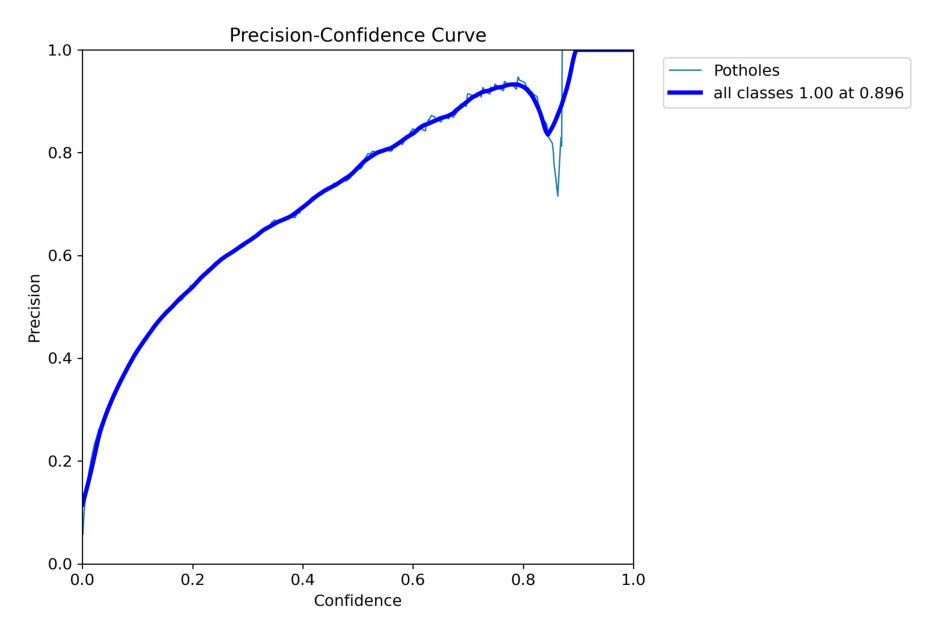

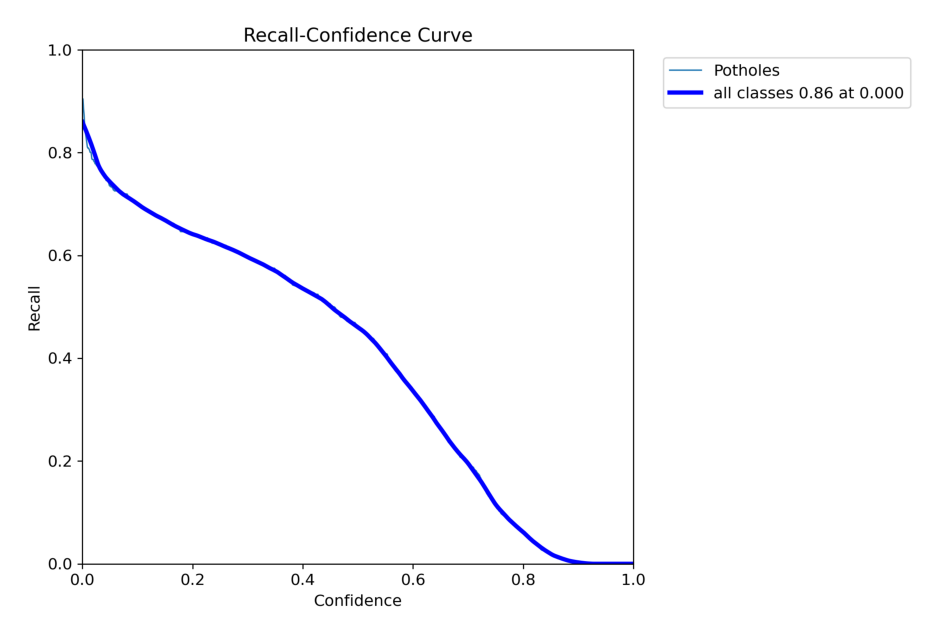

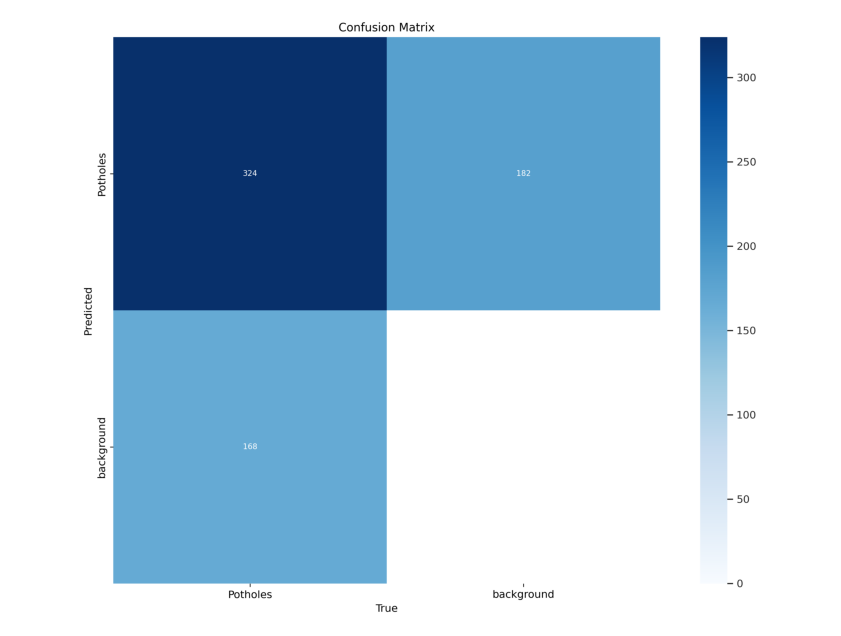

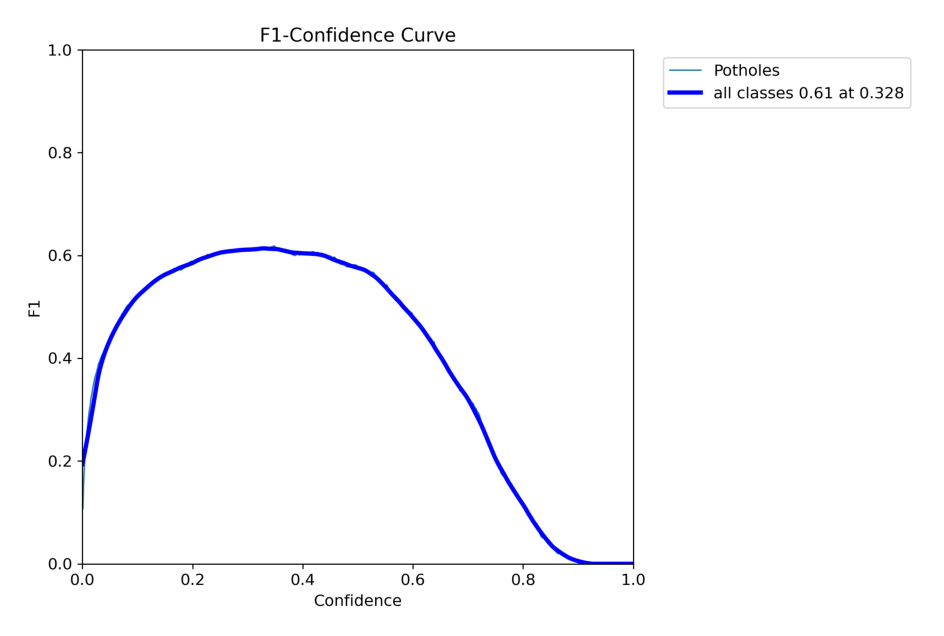

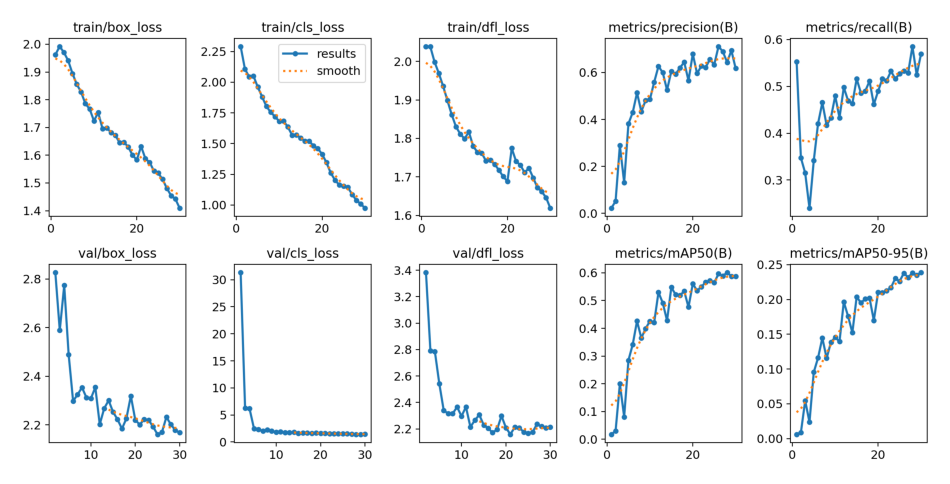

In [ ]:
list_of_metrics = ["P_curve.png", "R_curve.png", "confusion_matrix.png", "F1_curve.png", "results.png"]

for metric in list_of_metrics:
    image = Image.open(f'/content/runs/detect/train2/{metric}')
    plt.figure(figsize=(12, 8))
    plt.axis("off")
    plt.imshow(image)
    plt.show()


In [ ]:
trained_weights = "/content/runs/detect/train2/weights/best.pt"
model = YOLO(trained_weights)

In [ ]:
def test_visualization(images):
    output = model.predict(images)
    fig, axes = plt.subplots(3, 3, figsize=(11, 11))
    for i, r in enumerate(images):
        ax = axes[i // 3, i % 3]
        im_bgr = cv2.imread(r)
        im_rgb = Image.fromarray(im_bgr[..., ::-1])  # RGB-order PIL image
        ax.axis('off')
        ax.set_title(f"Image {i}")
        ax.imshow(im_rgb)
    fig, axes = plt.subplots(3, 3, figsize=(11, 11))
    for i, r in enumerate(output):
        ax = axes[i // 3, i % 3]
        im_bgr = r.plot()  # BGR-order numpy array
        im_rgb = Image.fromarray(im_bgr[..., ::-1])  # RGB-order PIL image
        ax.axis('off')
        ax.set_title(f"Image {i}")
        ax.imshow(im_rgb)



0: 512x512 2 Potholess, 24.9ms
1: 512x512 1 Potholes, 24.9ms
2: 512x512 4 Potholess, 24.9ms
3: 512x512 1 Potholes, 24.9ms
4: 512x512 16 Potholess, 24.9ms
5: 512x512 11 Potholess, 24.9ms
6: 512x512 3 Potholess, 24.9ms
7: 512x512 1 Potholes, 24.9ms
8: 512x512 1 Potholes, 24.9ms
Speed: 2.5ms preprocess, 24.9ms inference, 0.9ms postprocess per image at shape (1, 3, 512, 512)


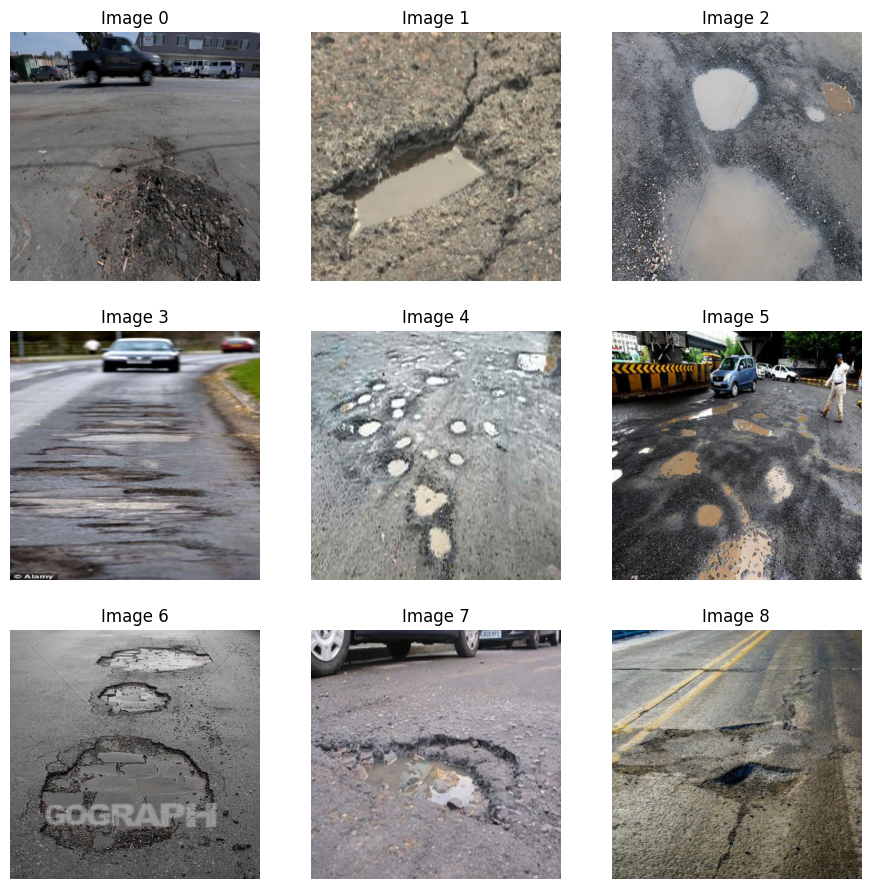

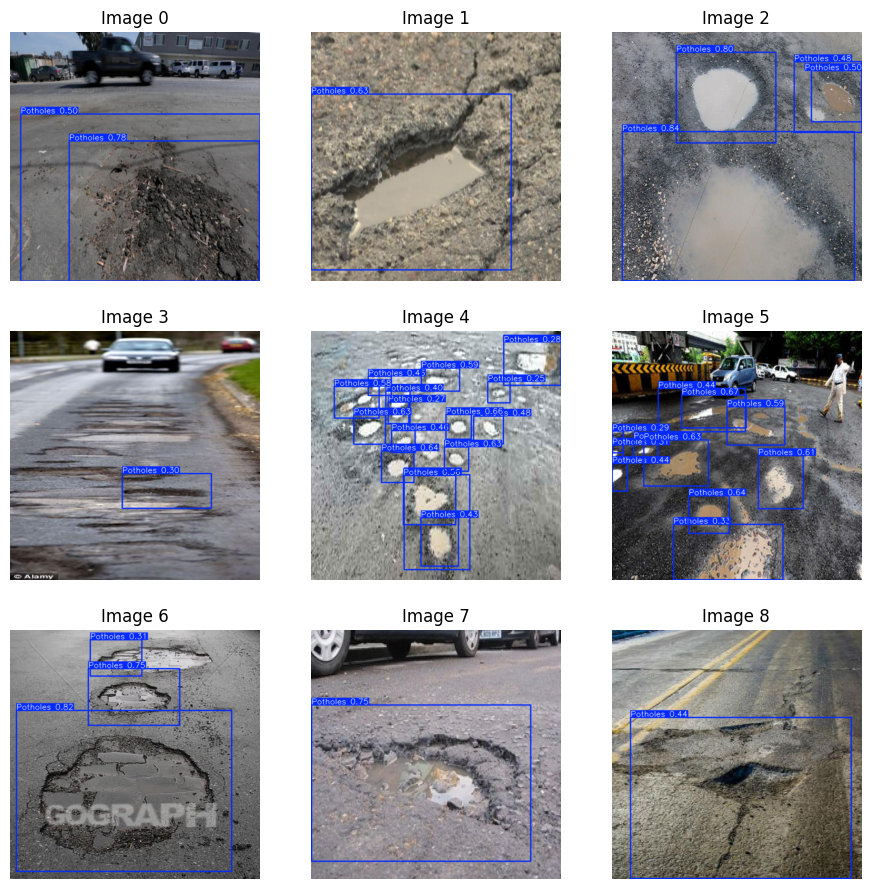

In [ ]:
test_img_dir = '/content/pathhole/Potholedetection/test/images'
test_images = os.listdir(test_img_dir)
test_img = [os.path.join(test_img_dir, img) for img in test_images[:9]]

test_visualization(test_img)

In [ ]:
import os
import shutil
import numpy as np
import pandas as pd
import pickle
from tensorflow.keras.utils import to_categorical
import plotly.express as px
import matplotlib.pyplot as plt
import seaborn as sns
from ultralytics import YOLO
import cv2
from PIL import Image
import torch
from torch import nn
import random

In [ ]:
from ultralytics import YOLO
import os

# Build a YOLOv9c model from scratch
model = YOLO("yolov9c.yaml")

# Build a YOLOv9c model from pretrained weight
model = YOLO("yolov9c.pt")

# Display model information (optional)
model.info()

# Train the model on the dataset for 20 epochs
model.train(data="/content/pathhole/Potholedetection/data.yaml", epochs=30, imgsz=640, lr0=0.0001, dropout=0.15)

# Path to save the model weights
save_path = '/content/yolov9c.pt'

# Save the model weights
model.save(save_path)


YOLOv9c summary: 618 layers, 25,590,912 parameters, 0 gradients, 104.0 GFLOPs
Ultralytics YOLOv8.2.57 🚀 Python-3.10.12 torch-2.3.0+cu121 CUDA:0 (Tesla T4, 15102MiB)
engine/trainer: task=detect, mode=train, model=yolov9c.pt, data=/content/pathhole/Potholedetection/data.yaml, epochs=30, time=None, patience=100, batch=16, imgsz=640, save=True, save_period=-1, cache=False, device=None, workers=8, project=None, name=train4, exist_ok=False, pretrained=True, optimizer=auto, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.15, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False, augment=False, agnostic_nms=False, classes=None, retina_masks=False, embed=None, show=False, save_frame

train: Scanning /content/pathhole/Potholedetection/train/labels.cache... 1245 images, 0 backgrounds, 0 corrupt: 100%|██████████| 1245/1245 [00:00<?, ?it/s]

albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01), CLAHE(p=0.01, clip_limit=(1, 4.0), tile_grid_size=(8, 8))



/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
val: Scanning /content/pathhole/Potholedetection/valid/labels.cache... 120 images, 0 backgrounds, 0 corrupt: 100%|██████████| 120/120 [00:00<?, ?it/s]


Plotting labels to runs/detect/train4/labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.0001' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.002, momentum=0.9) with parameter groups 154 weight(decay=0.0), 161 weight(decay=0.0005), 160 bias(decay=0.0)
TensorBoard: model graph visualization added ✅
Image sizes 640 train, 640 val
Using 2 dataloader workers
Logging results to runs/detect/train4
Starting training for 30 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       1/30      11.3G      1.952      2.411      2.113        100        640: 100%|██████████| 78/78 [01:05<00:00,  1.18it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:02<00:00,  1.59it/s]

                   all        120        492    0.00416      0.199     0.0022   0.000861



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       2/30      11.7G      1.987      2.199      2.108        131        640: 100%|██████████| 78/78 [01:00<00:00,  1.29it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:02<00:00,  1.51it/s]

                   all        120        492     0.0532      0.128     0.0229    0.00619



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       3/30      11.5G      1.983       2.15      2.099         63        640: 100%|██████████| 78/78 [01:00<00:00,  1.29it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:03<00:00,  1.18it/s]

                   all        120        492     0.0409      0.319     0.0227    0.00632



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       4/30      11.5G      1.939       2.13       2.06         79        640: 100%|██████████| 78/78 [01:00<00:00,  1.30it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:02<00:00,  1.47it/s]

                   all        120        492      0.236      0.301        0.2     0.0605



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       5/30      11.5G      1.895      2.069      2.031        103        640: 100%|██████████| 78/78 [01:00<00:00,  1.29it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:03<00:00,  1.31it/s]

                   all        120        492      0.149      0.291     0.0776     0.0222



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       6/30      11.6G      1.848      1.985      1.991         73        640: 100%|██████████| 78/78 [01:01<00:00,  1.27it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:02<00:00,  1.65it/s]

                   all        120        492      0.437      0.427       0.37      0.124



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       7/30      11.5G      1.816      1.914      1.948         92        640: 100%|██████████| 78/78 [01:00<00:00,  1.29it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:02<00:00,  1.70it/s]

                   all        120        492      0.409      0.374      0.323      0.106



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       8/30      11.5G      1.795      1.859      1.922         74        640: 100%|██████████| 78/78 [01:00<00:00,  1.29it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:03<00:00,  1.28it/s]

                   all        120        492      0.404      0.419      0.354      0.111



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       9/30      11.6G      1.766      1.807      1.899         50        640: 100%|██████████| 78/78 [01:00<00:00,  1.29it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:02<00:00,  1.69it/s]

                   all        120        492      0.475      0.386      0.357      0.122



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      10/30      11.5G      1.735      1.779        1.9        129        640: 100%|██████████| 78/78 [01:00<00:00,  1.28it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:02<00:00,  1.72it/s]

                   all        120        492      0.455      0.412      0.364      0.124



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      11/30      11.6G      1.746      1.773      1.883         95        640: 100%|██████████| 78/78 [01:00<00:00,  1.30it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:03<00:00,  1.29it/s]

                   all        120        492      0.508      0.455      0.421      0.146



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      12/30      11.5G      1.711      1.715      1.887         95        640: 100%|██████████| 78/78 [01:00<00:00,  1.29it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:02<00:00,  1.67it/s]

                   all        120        492      0.542      0.514      0.487      0.168



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      13/30      11.5G      1.713      1.665      1.872         97        640: 100%|██████████| 78/78 [01:00<00:00,  1.28it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:02<00:00,  1.67it/s]

                   all        120        492      0.525      0.457      0.448      0.158



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      14/30      11.6G       1.69      1.676      1.854        122        640: 100%|██████████| 78/78 [01:00<00:00,  1.30it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:02<00:00,  1.72it/s]

                   all        120        492      0.509      0.455       0.42      0.139



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      15/30      11.5G      1.663      1.591      1.816         94        640: 100%|██████████| 78/78 [01:00<00:00,  1.28it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:02<00:00,  1.69it/s]

                   all        120        492       0.58      0.504      0.525      0.182



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      16/30      11.6G       1.65      1.583      1.835         72        640: 100%|██████████| 78/78 [01:00<00:00,  1.30it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:02<00:00,  1.70it/s]

                   all        120        492      0.572      0.467      0.497      0.191



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      17/30      11.5G      1.667      1.586      1.831         96        640: 100%|██████████| 78/78 [01:00<00:00,  1.29it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:02<00:00,  1.72it/s]

                   all        120        492      0.569      0.528      0.526       0.21



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      18/30      11.5G      1.644      1.555      1.825        144        640: 100%|██████████| 78/78 [01:00<00:00,  1.29it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:02<00:00,  1.46it/s]

                   all        120        492      0.584      0.496      0.518      0.192



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      19/30      11.6G      1.609      1.539      1.807         73        640: 100%|██████████| 78/78 [00:59<00:00,  1.30it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:03<00:00,  1.28it/s]

                   all        120        492      0.556      0.539      0.528      0.186



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      20/30      11.5G      1.597      1.488      1.775        112        640: 100%|██████████| 78/78 [01:00<00:00,  1.29it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:02<00:00,  1.68it/s]

                   all        120        492      0.607      0.514      0.546      0.206


Closing dataloader mosaic
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01), CLAHE(p=0.01, clip_limit=(1, 4.0), tile_grid_size=(8, 8))


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      21/30      11.5G      1.648      1.417      1.884         44        640: 100%|██████████| 78/78 [01:01<00:00,  1.26it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:02<00:00,  1.67it/s]

                   all        120        492      0.594      0.488      0.503      0.178



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      22/30      11.5G      1.618      1.346       1.86         46        640: 100%|██████████| 78/78 [00:59<00:00,  1.30it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:02<00:00,  1.38it/s]

                   all        120        492      0.635      0.472      0.507      0.191



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      23/30      11.5G      1.608      1.296      1.864         31        640: 100%|██████████| 78/78 [00:59<00:00,  1.31it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:02<00:00,  1.71it/s]

                   all        120        492      0.654       0.49      0.558      0.217



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      24/30      11.6G      1.583      1.251      1.837         37        640: 100%|██████████| 78/78 [00:59<00:00,  1.30it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:02<00:00,  1.66it/s]

                   all        120        492      0.639      0.496      0.545      0.204



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      25/30      11.6G      1.568      1.229      1.838         76        640: 100%|██████████| 78/78 [00:59<00:00,  1.31it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:02<00:00,  1.62it/s]

                   all        120        492      0.638      0.518       0.56      0.219



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      26/30      11.5G      1.526      1.207      1.806         50        640: 100%|██████████| 78/78 [00:59<00:00,  1.31it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:02<00:00,  1.48it/s]

                   all        120        492       0.63      0.535      0.567      0.225



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      27/30      11.6G      1.513      1.146      1.799         71        640: 100%|██████████| 78/78 [00:59<00:00,  1.31it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:02<00:00,  1.69it/s]

                   all        120        492      0.661      0.491      0.563      0.224



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      28/30      11.5G      1.484      1.106       1.78         24        640: 100%|██████████| 78/78 [01:00<00:00,  1.29it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:02<00:00,  1.72it/s]

                   all        120        492      0.684       0.51      0.578      0.232



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      29/30      11.5G      1.464      1.072       1.76         58        640: 100%|██████████| 78/78 [01:00<00:00,  1.30it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:02<00:00,  1.68it/s]

                   all        120        492      0.633      0.551      0.595      0.228



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      30/30      11.5G      1.445      1.037      1.738         63        640: 100%|██████████| 78/78 [00:59<00:00,  1.30it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:02<00:00,  1.64it/s]

                   all        120        492      0.651      0.514      0.575      0.232



30 epochs completed in 0.568 hours.
Optimizer stripped from runs/detect/train4/weights/last.pt, 51.6MB
Optimizer stripped from runs/detect/train4/weights/best.pt, 51.6MB

Validating runs/detect/train4/weights/best.pt...
Ultralytics YOLOv8.2.57 🚀 Python-3.10.12 torch-2.3.0+cu121 CUDA:0 (Tesla T4, 15102MiB)
YOLOv9c summary (fused): 384 layers, 25,320,019 parameters, 0 gradients, 102.3 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:06<00:00,  1.64s/it]


                   all        120        492      0.655      0.514      0.575      0.232
Speed: 0.4ms preprocess, 17.5ms inference, 0.0ms loss, 4.4ms postprocess per image
Results saved to runs/detect/train4


In [ ]:
trained_weights = "/content/runs/detect/train4/weights/best.pt"
model = YOLO(trained_weights)

# Evaluate the model on the validation set
results = model.val(data = '/content/pathhole/Potholedetection/data.yaml')

# Print the evaluation metrics
# Accessing metrics using the appropriate methods
precision = results.box.mp # Mean precision
recall = results.box.mr    # Mean recall
mAP50 = results.box.map50  # mAP@0.5
mAP50_95 = results.box.map  # mAP@0.5:0.95

print(f"Precision: {precision}")
print(f"Recall: {recall}")
print(f"mAP@0.5: {mAP50}")
print(f"mAP@0.5:0.95: {mAP50_95}")


Ultralytics YOLOv8.2.57 🚀 Python-3.10.12 torch-2.3.0+cu121 CUDA:0 (Tesla T4, 15102MiB)
YOLOv9c summary (fused): 384 layers, 25,320,019 parameters, 0 gradients, 102.3 GFLOPs


val: Scanning /content/pathhole/Potholedetection/valid/labels.cache... 120 images, 0 backgrounds, 0 corrupt: 100%|██████████| 120/120 [00:00<?, ?it/s]
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:08<00:00,  1.05s/it]


                   all        120        492      0.654      0.512      0.571      0.231
Speed: 2.2ms preprocess, 31.6ms inference, 0.5ms loss, 10.3ms postprocess per image
Results saved to runs/detect/val2
Precision: 0.6537688006841108
Recall: 0.5121951219512195
mAP@0.5: 0.5713060006963275
mAP@0.5:0.95: 0.23138675986459595


In [ ]:
import os
import random
import pandas as pd
from PIL import Image
import cv2
from ultralytics import YOLO
from IPython.display import Video
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style='darkgrid')
import pathlib
import glob
from tqdm.notebook import trange, tqdm
import warnings
warnings.filterwarnings('ignore')

In [ ]:
trained_weights = "/content/runs/detect/train4/weights/best.pt"
model = YOLO(trained_weights)

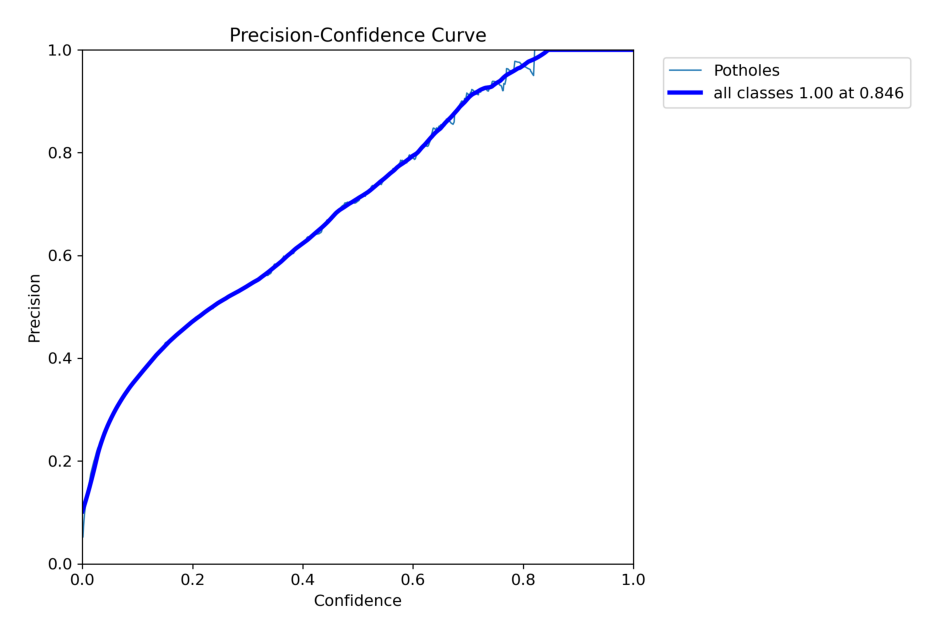

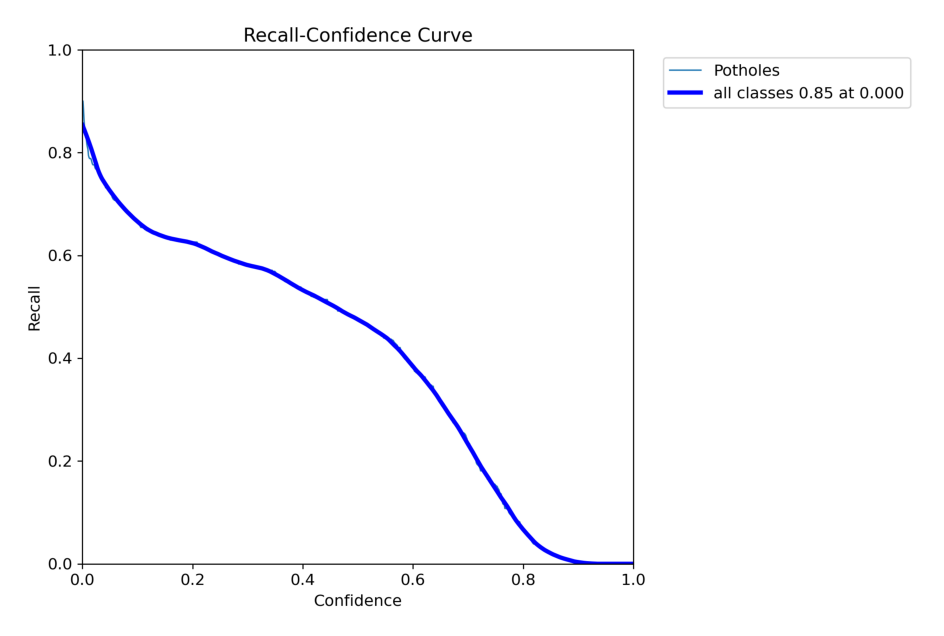

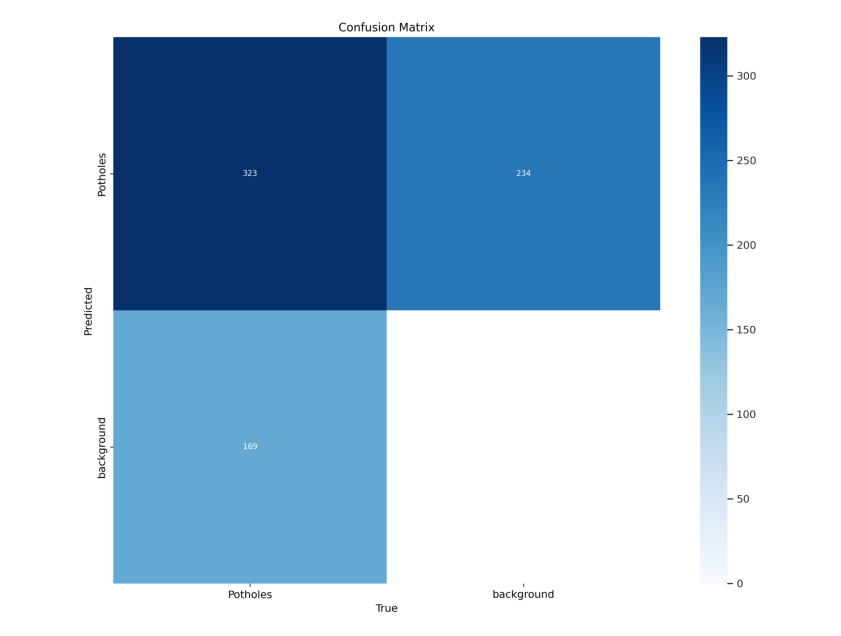

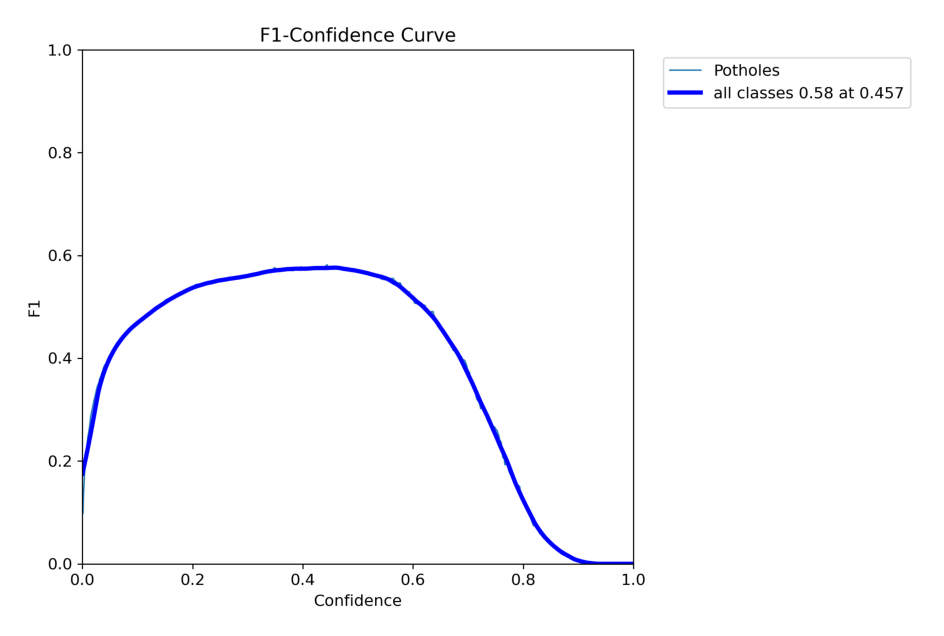

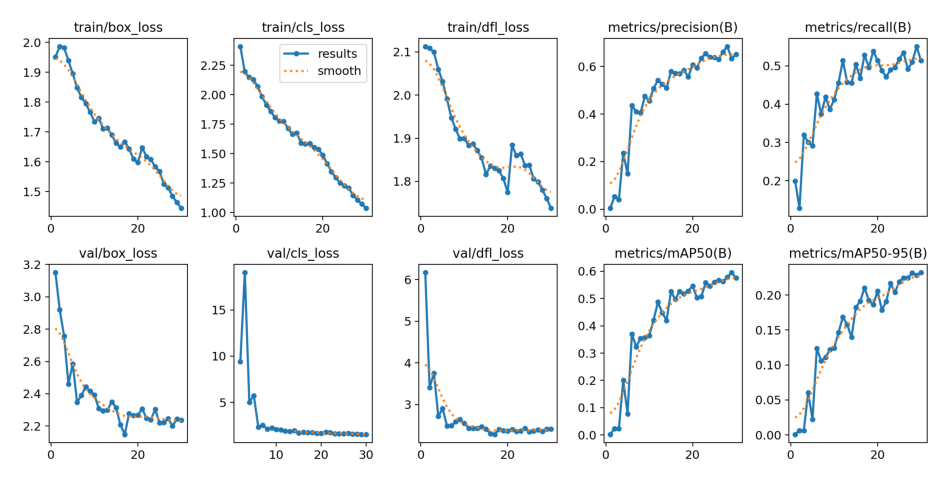

In [ ]:
list_of_metrics = ["P_curve.png", "R_curve.png", "confusion_matrix.png", "F1_curve.png", "results.png"]

for metric in list_of_metrics:
    image = Image.open(f'/content/runs/detect/train4/{metric}')
    plt.figure(figsize=(12, 8))
    plt.axis("off")
    plt.imshow(image)
    plt.show()


In [ ]:
def test_visualization(images):
    output = model.predict(images)
    fig, axes = plt.subplots(3, 3, figsize=(11, 11))
    for i, r in enumerate(images):
        ax = axes[i // 3, i % 3]
        im_bgr = cv2.imread(r)
        im_rgb = Image.fromarray(im_bgr[..., ::-1])  # RGB-order PIL image
        ax.axis('off')
        ax.set_title(f"Image {i}")
        ax.imshow(im_rgb)
    fig, axes = plt.subplots(3, 3, figsize=(11, 11))
    for i, r in enumerate(output):
        ax = axes[i // 3, i % 3]
        im_bgr = r.plot()  # BGR-order numpy array
        im_rgb = Image.fromarray(im_bgr[..., ::-1])  # RGB-order PIL image
        ax.axis('off')
        ax.set_title(f"Image {i}")
        ax.imshow(im_rgb)


0: 640x640 1 Potholes, 34.3ms
1: 640x640 1 Potholes, 34.3ms
2: 640x640 5 Potholess, 34.3ms
3: 640x640 1 Potholes, 34.3ms
4: 640x640 20 Potholess, 34.3ms
5: 640x640 11 Potholess, 34.3ms
6: 640x640 5 Potholess, 34.3ms
7: 640x640 1 Potholes, 34.3ms
8: 640x640 2 Potholess, 34.3ms
Speed: 1.8ms preprocess, 34.3ms inference, 1.2ms postprocess per image at shape (1, 3, 640, 640)


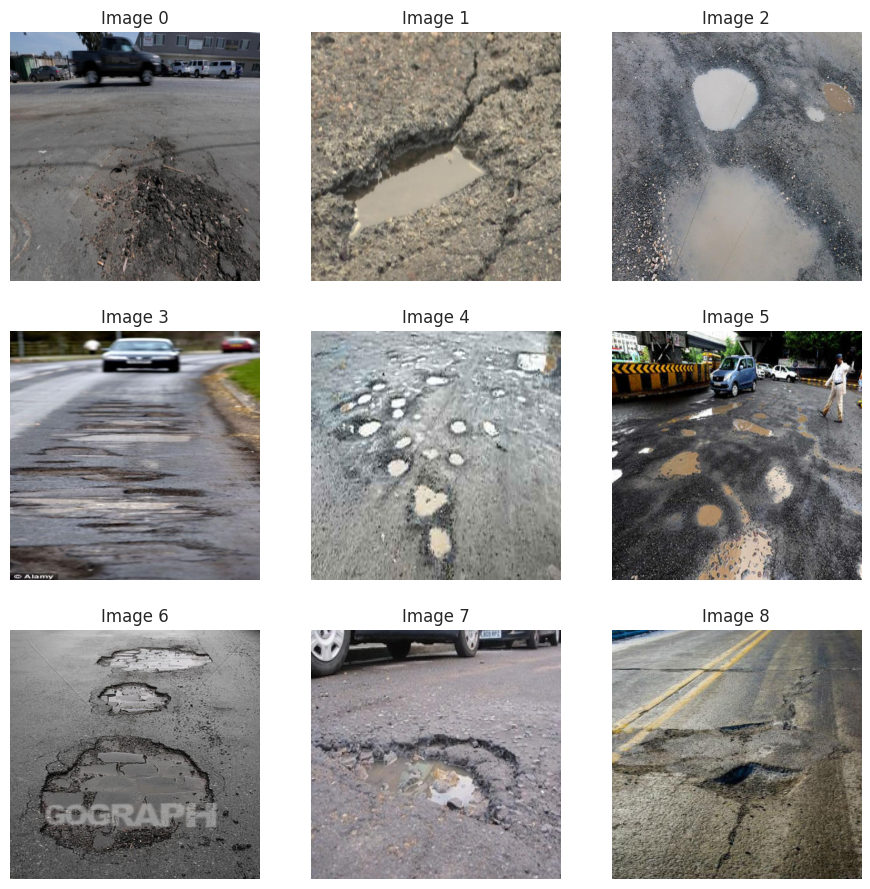

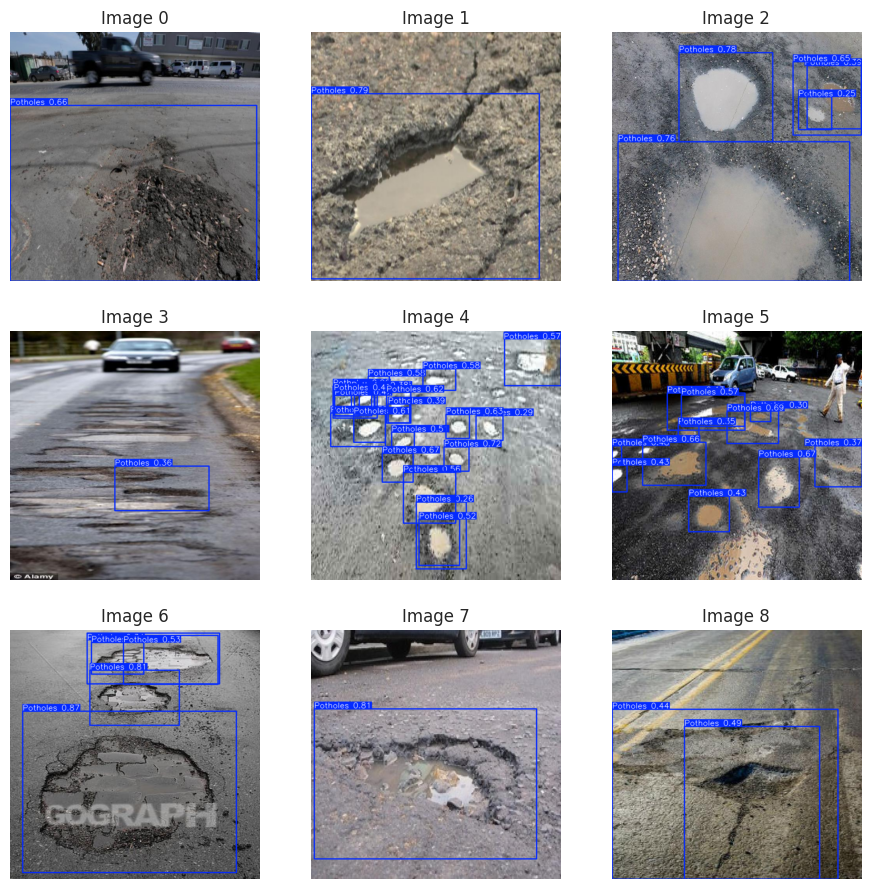

In [ ]:
test_img_dir = '/content/pathhole/Potholedetection/test/images'
test_images = os.listdir(test_img_dir)
test_img = [os.path.join(test_img_dir, img) for img in test_images[:9]]

test_visualization(test_img)

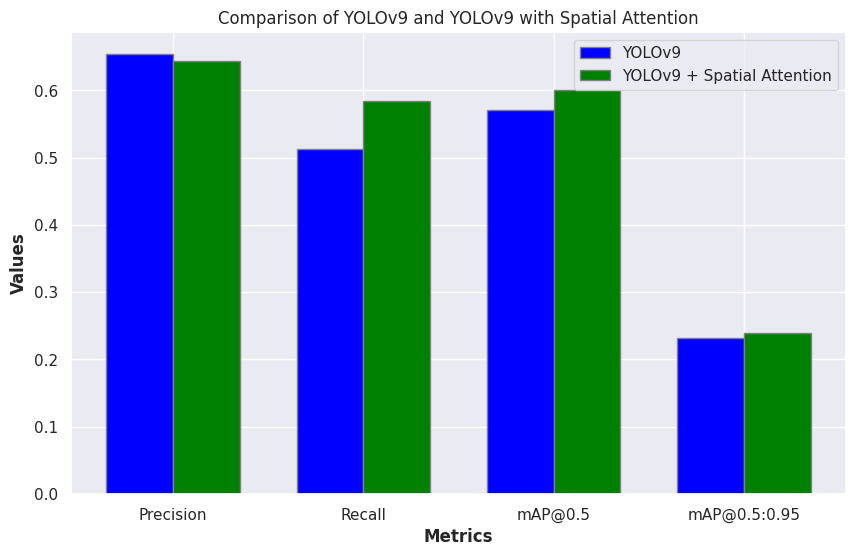

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Metrics for YOLOv9
yolo_v9_metrics = {
    'Precision': 0.6537688006841108,
    'Recall': 0.5121951219512195,
    'mAP@0.5': 0.5713060006963275,
    'mAP@0.5:0.95': 0.23138675986459595
}

# Metrics for YOLOv9 with Spatial Attention
yolo_v9_sa_metrics = {
    'Precision': 0.6439545697566453,
    'Recall': 0.5844975064660266,
    'mAP@0.5': 0.6008312111148117,
    'mAP@0.5:0.95': 0.238994866178497
}

# Names of the metrics
metrics = list(yolo_v9_metrics.keys())

# Values of the metrics
yolo_v9_values = list(yolo_v9_metrics.values())
yolo_v9_sa_values = list(yolo_v9_sa_metrics.values())

# Bar width
bar_width = 0.35

# Positions of the bars on the x-axis
r1 = np.arange(len(metrics))
r2 = [x + bar_width for x in r1]

# Create the plot
plt.figure(figsize=(10, 6))

# Plot bars
plt.bar(r1, yolo_v9_values, color='blue', width=bar_width, edgecolor='grey', label='YOLOv9')
plt.bar(r2, yolo_v9_sa_values, color='green', width=bar_width, edgecolor='grey', label='YOLOv9 + Spatial Attention')

# Add labels
plt.xlabel('Metrics', fontweight='bold')
plt.ylabel('Values', fontweight='bold')
plt.title('Comparison of YOLOv9 and YOLOv9 with Spatial Attention')
plt.xticks([r + bar_width / 2 for r in range(len(metrics))], metrics)

# Add legend
plt.legend()

# Display the plot
plt.show()
